# Work out a way to find the path between a start and endpoint

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import lumiere as lm
lm.loadstyle(True)

Using KIT colors.
Custom style set.


In [2]:
width = 200
height = 100

In [3]:
def reflect(pos, wall):
    if wall == 'AB':
        return [pos[0], -pos[1]]
    if wall == 'CD':
        return [pos[0], 2*height - pos[1]]
    if wall == 'BC':
        return [2*width - pos[0], pos[1]]
    if wall == 'DA':
        return [-pos[0], pos[1]]
    print('Error')

def calculateAngle(A, Bstar):
    return np.rad2deg(2*np.pi + np.arctan2(Bstar[1]-A[1], Bstar[0]-A[0])) % 360


def line(x, a, b):
    return x*a + b

def angle2line(x, x0, y0, alpha0):
    return np.tan(np.deg2rad(alpha0))*(x-x0) + y0

def inv_angle2line(y, x0, y0, alpha0):
    return (y-y0)/np.tan(np.deg2rad(alpha0)) + x0
    
def newCollsionPoint(x, y, alpha):
    yleft = angle2line(0, x, y, alpha)
    yright = angle2line(width, x, y, alpha)
    xbottom = inv_angle2line(0, x, y, alpha)
    xtop = inv_angle2line(height, x, y, alpha)


    if alpha < 90: # collision top-right
        if xtop > width:
            return (width, yright, 180-alpha) # collision right vertical
        else: 
            return (xtop, height, 360-alpha) # collision top horizontal
        
    if alpha < 180: # collsion top left
        if yleft > height:
            return (xtop, height, 360-alpha) # collision top horizontal

        else:
            return (0, yleft, 180-alpha) # collision left vertical


    if alpha < 270: # collsion bottom left
        if xbottom < 0:
            return (0, yleft, 540-alpha) # collision left vertical
        else:
            return (xbottom, 0, 360-alpha) # collision bottom horizontal
        
    # collision bottom right
    if xbottom > width:
        return (width, yright, 540-alpha) # collision right vertical
    else:
        return (xbottom, 0, 360-alpha) # collision bottom horizontal
    


In [4]:
def plotTable(mirrorpath, aimpath, width, height):
    x_coords = [pos[0] for pos in mirrorpath]
    y_coords = [pos[1] for pos in mirrorpath]

    plt.plot(x_coords, y_coords, '--', color='C1', label='MIRROR CALCULATION')

    plt.plot([aimpath[0][0], x_coords[0-1]], [aimpath[1][0], y_coords[-1]], ':', color='C5', label='AIM PATH')
    plt.plot(x_coords[-1], y_coords[-1], 'o', color='r', label='AIM TARGET')

    plt.plot(*aimpath, color='C2', label='PLAYPATH')

    
    plt.plot([0, width, width, 0, 0], [0, 0, height, height, 0], color='k')
    plt.scatter(*A, color='C0', label='BEGIN')
    plt.scatter(*B, color='C1', label='END')
    plt.text(5, 3, 'A')
    plt.text(203, 3, 'B')
    plt.text(203, 3, 'B')
    plt.text(203, 97, 'C')
    plt.text(5, 97, 'D')
    

### Best to think about this in terms of billiard

- we want to play from $A$ to $B$
- so we specify the order of walls $AB, BC, CD, DA$ we want to play of
- we aim at the virtual image of $B$, that is created by mirroring in an inverted order
- what we look for is then the angle $\alpha$
$$
    \alpha = \arctan \left( \frac{y_{B^*}- y_{A}}{x_{B^*} - x_A} \right)
$$

[[78, 87], [322, 87], [-322, 87], [722, 87], [722, -87]]


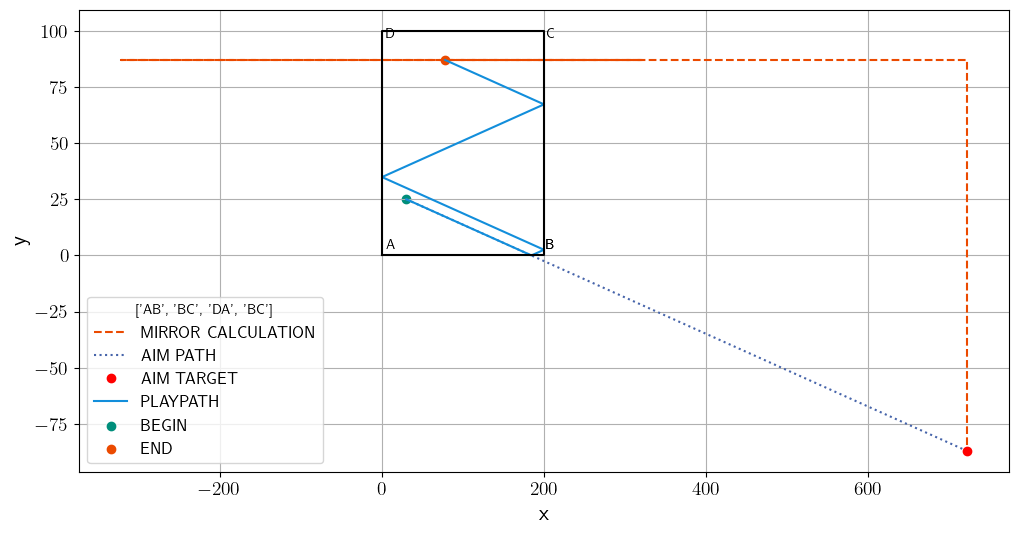

In [5]:
A = [30, 25]
B = [78, 87]
width = 200
height = 100

path = [B]
bounces = ['AB', 'BC', 'DA', 'BC'] #from A to B


for ref in bounces[::-1]:
    nup = reflect(path[-1], ref)
    path.append(nup)
print(path)
# this is the virtual path


#this is the angle going out from A
alpha = calculateAngle(A, path[-1])
x0v, y0v, a0v = [A[0]], [A[1]], [alpha]

for i  in range(len(bounces)+1):
    xx, yy, aa = newCollsionPoint(x0v[-1], y0v[-1], a0v[-1])
    x0v.append(xx)
    y0v.append(yy)
    a0v.append(aa)

x0v[-1] = B[0]
y0v[-1] = B[1]
plotTable(path, [x0v, y0v], width, height)


plt.xlabel('x')
plt.ylabel('y')
plt.legend(title=str(bounces))
plt.show()


In [6]:
import sys
cdir = %pwd
sys.path.append(cdir+ '/')
from collision_builder import *

### function added to collision_builder

In [7]:
def addPrimaryFrom(self, start_pos, wall_collisions):
    '''
    - start_pos: a (x, y)
    - wall collisions: Combination of "AB", "BC", "CD", "DA" [[path1], [path2], ...] (in time-forward order)
    ---------------------------------------
    Calculate and Save the path(s) to be taken from start_pos (a) -> point_of_collision (b)
    '''

    n_bounces = []
    # allow multiple paths to be computed
    for this_wall_collision_path in wall_collisions:

        # calculate virtual endpoint
        virtual_end_pos = start_pos.copy()
        for coll in this_wall_collision_path[::-1]:
            virtual_end_pos = reflect(virtual_end_pos, coll)


        # calculate angle going out from a, aimed at virtual b
        start_alpha = calculateAngle(self.point_of_contact, virtual_end_pos)

        self.incoming_angles.append(start_alpha)
        n_bounces.append(len(this_wall_collision_path))


    # compute the paths of collision
    self.calculatePrimaryPaths(n_bounces)

    # need to add a last point: b
    for i in range(len(self.primary_paths)):
        self.primary_paths[i][0].append(start_pos[0])
        self.primary_paths[i][1].append(start_pos[1])



## testing

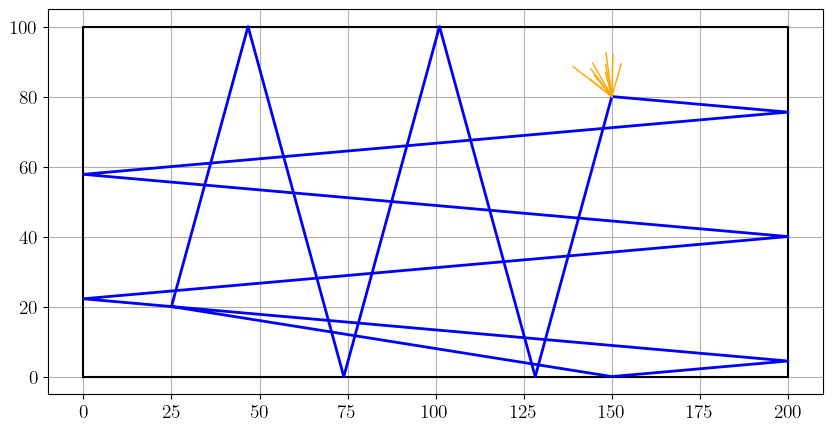

Writen to temp.svg!


In [8]:
#CollisionBuider.addPrimaryFrom = addPrimaryFrom

a = [25, 20]
b = [150, 80]

collisions_paths = [['BC', 'AB', 'DA', 'BC', 'AB', 'DA'],
                    ['AB', 'CD', 'AB', 'CD']]

builder = CollisionBuider(width=200, height=100, point_of_contact=b, incoming_angles=[])

builder.addPrimaryFrom(a, collisions_paths)
builder.calculateSecondaryPaths(10)

builder.plotResult()
builder.to_svg('temp.svg')

In [9]:
builder.primary_paths

[[[150, 200, 0, 200, 0, 200, 150.0000000000071, 25],
  [80,
   75.55555555555553,
   57.7777777777776,
   39.99999999999969,
   22.22222222222176,
   4.44444444444385,
   0,
   20]],
 [[150,
   128.26086956521738,
   101.08695652173911,
   73.91304347826085,
   46.73913043478258,
   25],
  [80, 0, 100, 0, 100, 20]]]

## A class to wrap multiple collisions

- `collision_builder.py` can create the svg for one collision
- we want to have a sequence of $n$ multiple collisions
---
- for i in range(n):
  - create a collisionBuilder
  - calculate primary path from $(x_i, y_i) \to (x_{i+1}, y_{i+1})$
  - calculate secondary paths
  - turn primaries into svg-paths
    - set style-parameters
    - set identifier with index i
    - set reset times: (i-1).end - 0.001
    - set start times: (i-1).end

- initialized with a starting point

- the class stores a list of collisionBuilder:
  - a method takes
    - new point of collision
    - paths from prev poc to new poc
    - maybe option to randomize the path and position
    - style-parameters

In [10]:
class ConsecutiveCollisionBuilder:
    def __init__(self, width, height, inital_point, relative_margin=0.05):
        self.points_of_collision = [inital_point]
        self.collisions = []
        self.relative_margin = relative_margin
        self.width = width
        self.height = height

        self.default_config = {
            'n_secondaries': 10,
            'alpha_std': 30,
            'length_mean': 100,
            'length_std': 30,
            'primary_color': '#ffffff',
            'secondary_color': '#ccbb00',
            'box_color': '#3c3c3c',
            'background_color': '#dc7474',
            'primary_stroke_width': 5,
            'secondary_stroke_width': 3,
            'primary_begin': 0,
            'secondary_duration': 1,
            'primary_duration': 5,
            'dur_fade_primary': 0.5,
            'dur_fade_secondary': 0.5,
            'dur_freeze_secondary': 0
            }

    def addCollision(self, new_point_of_collision, border_collisions, **kwargs):
        
        config = self.default_config.copy()
        config.update(kwargs)

        new_collision = CollisionBuider(self.width, self.height, new_point_of_collision,
                                        incoming_angles=[], relative_margin=self.relative_margin)
        
        new_collision.addPrimaryFrom(self.points_of_collision[-1], border_collisions)

        new_collision.calculateSecondaryPaths(n_secondaries=config['n_secondaries'],
                                            alpha_std=config['alpha_std'],
                                            length_mean=config['length_mean'],
                                            length_std=config['length_std'])


        style_dict = {k: v for k, v in config.items() if k not in ['n_secondaries', 'alpha_std', 'length_mean', 'length_std']}
        new_collision.setStyle(collision_index=len(self.collisions), **style_dict)

        self.points_of_collision.append(new_point_of_collision)
        self.collisions.append(new_collision)


    def to_svg(self, file_name):
        # closing the loop
        #self.addCollision(self.points_of_collision[0], [['AB'], ['BC', 'CD']])
        

        #begin the string
        total_string = f'<svg xmlns="http://www.w3.org/2000/svg" width="{self.width}" height="{self.height}" viewBox="0 0 {self.width} {self.height}">\n\n'


        # background box
        d_box = f'M0,0 L{self.width},0 L{self.width},{self.height} L0,{self.height} Z'
        box_string = line2svgPath(d=d_box, identifier='box',
                                  color=self.default_config['background_color'],
                                  stroke_width=0, animate=False, fill=self.default_config['background_color'])
        total_string += box_string + '\n\n'   


        # rescaling and translation to center
        scale_w = 1 - self.relative_margin
        scale_h = round(1 - self.width * self.relative_margin / self.height, 3)
        translation = self.relative_margin*self.width/2
        total_string += f'<g transform="scale({scale_w},{scale_h}) translate({translation}, {translation})"> \n\n'


        # surrounding box
        d_box = f'M0,0 L{self.width},0 L{self.width},{self.height} L0,{self.height} Z'
        box_string = line2svgPath(d=d_box, identifier='box',
                                  color=self.default_config['box_color'], stroke_width=0.5, animate=False, fill=self.default_config['box_color'])
        total_string += box_string + '\n\n'   

        # for each collision add the paths
        for coll in self.collisions:
            total_string += coll.prepare_for_multi_svg('templates/path_template.txt', len(self.collisions)-1)



        #end the string
        total_string += '\n\n</g>\n\n</svg>'

        # write
        with open(file_name, 'w') as file:
            file.write(total_string)
        
        print(f'Writen to {file_name}!')






- svg header: width heigt
- background box
- rescale and translate to center:
  - inner box
  - loop over collisions: maybe make this a method in a collision: returns the total block
    - loop over primary paths : funcion to turn into a path with the right animation
    - loop over secondary paths: funcion to turn into a path with the right animation
    - 

In [18]:
ccb = ConsecutiveCollisionBuilder(800, 400, [300, 100])
ccb.addCollision([100, 200], [['CD', 'DA']], primary_duration=2)
ccb.addCollision([300, 100], [['AB', 'BC']], primary_duration=2, dur_freeze_secondary=0.5)
ccb.to_svg('multi_collision.svg')

Writen to multi_collision.svg!


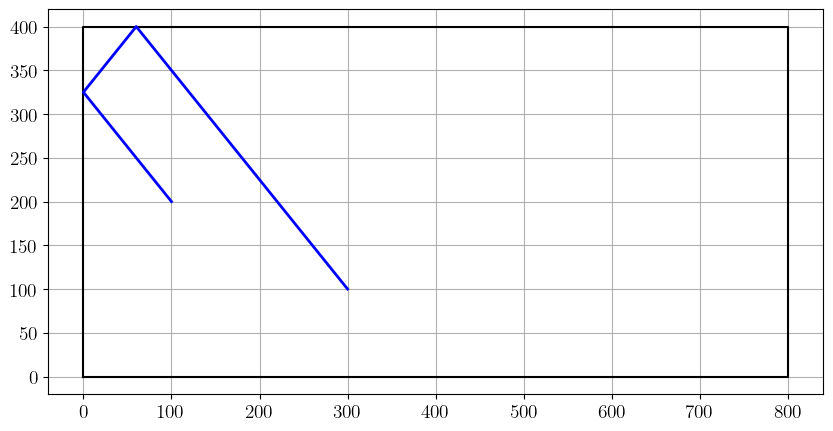

In [12]:
#CollisionBuider.addPrimaryFrom = addPrimaryFrom

b = [300, 100]
a = [100, 200]

collisions_paths = [['CD', 'DA']]


builder = CollisionBuider(width=800, height=400, point_of_contact=b, incoming_angles=[])

builder.addPrimaryFrom(a, collisions_paths)
builder.calculateSecondaryPaths(0)

builder.plotResult()

In [13]:
def plotTable(mirrorpath, aimpath, width, height):
    x_coords = [pos[0] for pos in mirrorpath]
    y_coords = [pos[1] for pos in mirrorpath]

    plt.plot(x_coords, y_coords, '--', color='C1', label='MIRROR CALCULATION')

    plt.plot([aimpath[0][0], x_coords[0-1]], [aimpath[1][0], y_coords[-1]], ':', color='C5', label='AIM PATH')
    plt.plot(x_coords[-1], y_coords[-1], 'o', color='r', label='AIM TARGET')

    plt.plot(*aimpath, color='C2', label='PLAYPATH')

    
    plt.plot([0, width, width, 0, 0], [0, 0, height, height, 0], color='k')
    plt.scatter(*A, color='C0', label='BEGIN')
    plt.scatter(*B, color='C1', label='END')
    
    plt.text(-10, -10, 'A')
    plt.text(width-3, -10, 'B')
    plt.text(width-3, height-7, 'C')
    plt.text(-10, height-10, 'D')
    

In [14]:
def reflect(pos, wall, width, height):
    if wall == 'AB':
        return [pos[0], -pos[1]]
    if wall == 'CD':
        return [pos[0], 2*height - pos[1]]
    if wall == 'BC':
        return [2*width - pos[0], pos[1]]
    if wall == 'DA':
        return [-pos[0], pos[1]]
    print('Error')

[[100, 200], [100, 600], [-100, 600]]
128.65980825409008


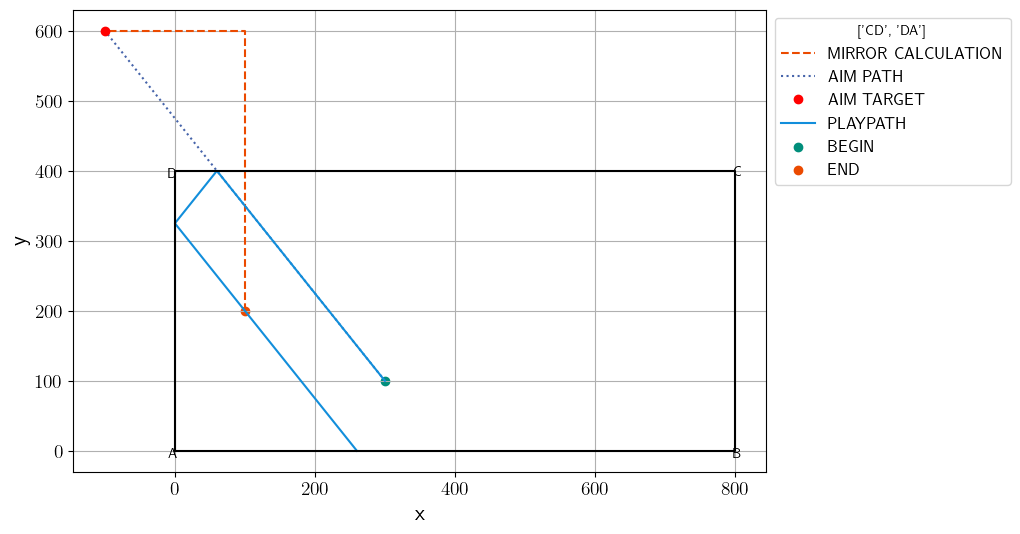

In [15]:
A = [300, 100]
B = [100, 200]

path = [B]
bounces = ['CD', 'DA'] #from A to B


width = 800
height = 400

for ref in bounces:
    nup = reflect(path[-1], ref, width, height)
    path.append(nup)
print(path)
# this is the virtual path

#this is the angle going out from A
alpha = calculateAngle(A, path[-1]) %360

print(alpha)
x0v, y0v, a0v = [A[0]], [A[1]], [alpha]

for i  in range(len(bounces)+1):
    xx, yy, aa = newCollsionPoint(x0v[-1], y0v[-1], a0v[-1], width=width, height=height)
    x0v.append(xx)
    y0v.append(yy)
    a0v.append(aa)

#x0v[-1] = B[0]
#y0v[-1] = B[1]
plotTable(path, [x0v, y0v], width, height)


plt.axis('scaled')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title=str(bounces), bbox_to_anchor=(1., 1.), loc='upper left', ncol=1)
plt.show()


In [16]:
466%360

106

In [17]:
def newCollsionPoint(x, y, alpha):
    yleft = angle2line(0, x, y, alpha)
    yright = angle2line(width, x, y, alpha)
    xbottom = inv_angle2line(0, x, y, alpha)
    xtop = inv_angle2line(height, x, y, alpha)


    if alpha < 90: # collision top-right
        if xtop > width:
            return (width, yright, 180-alpha) # collision right vertical
        else: 
            return (xtop, height, 360-alpha) # collision top horizontal
        
    if alpha < 180: # collsion top left
        if yleft > height:
            return (xtop, height, 360-alpha) # collision top horizontal

        else:
            return (0, yleft, 180-alpha) # collision left vertical


    if alpha < 270: # collsion bottom left
        if xbottom < 0:
            return (0, yleft, 540-alpha) # collision left vertical
        else:
            return (xbottom, 0, 360-alpha) # collision bottom horizontal
        
    # collision bottom right
    if xbottom > width:
        return (width, yright, 540-alpha) # collision right vertical
    else:
        return (xbottom, 0, 360-alpha) # collision bottom horizontal
    
